# Plot Effect of Tuning Parameter on Ridge Coefficients
We train logistic regression models with ridge (L2) regularization for each λ in a grid of values using scikit-learn. We then plot the effect of λ on the inferred coefficients for each of the 5 classes across 10 features.

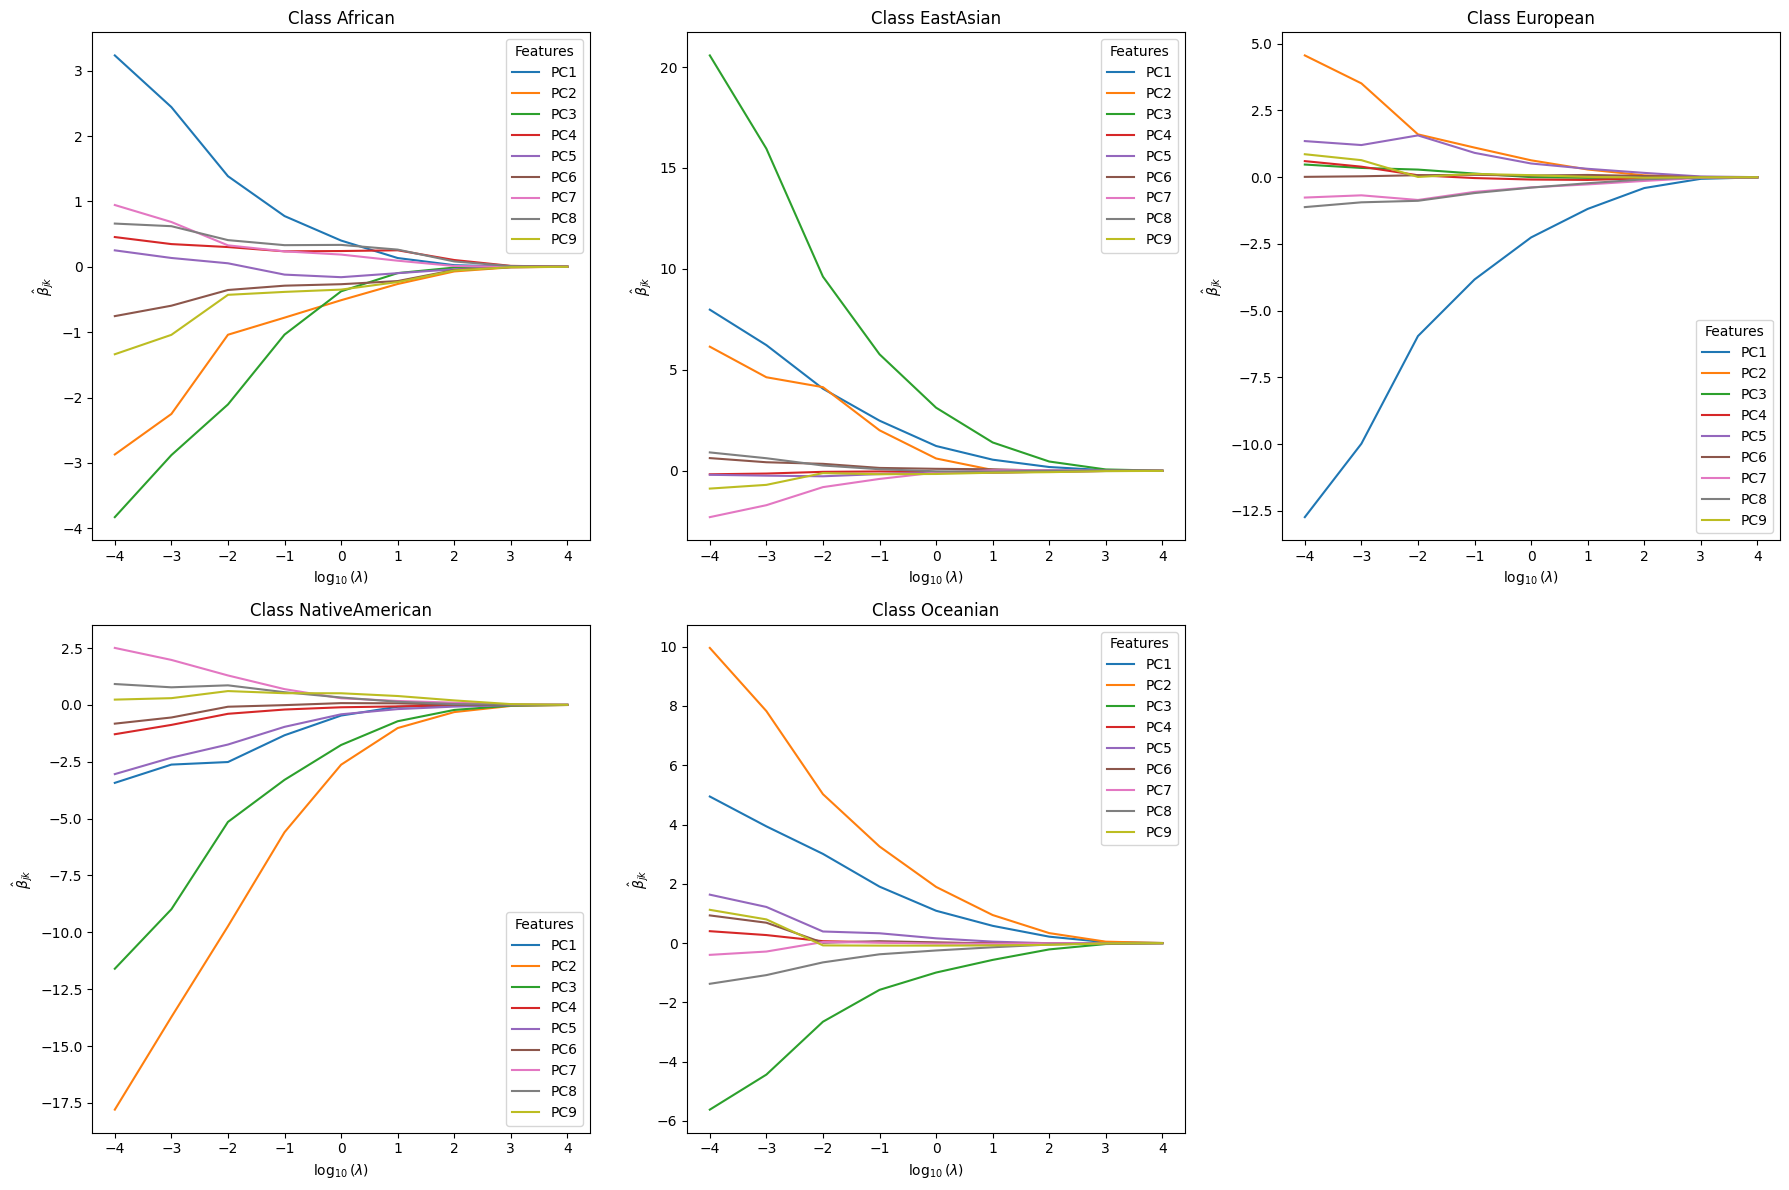

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings


# Suppress specific FutureWarnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="'multi_class' was deprecated in version 1.5 and will be removed in 1.7"
)

# Load and process data
train_data = pd.read_csv("/content/TrainingData_N183_p10.csv")
X = train_data.iloc[:, 1:-1].values  # Features (PC1 to PC10)
y_labels = train_data['Ancestry'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define lambda values
lambda_values = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
log_lambda_values = np.log10(lambda_values)

# Prepare storage for coefficients
num_classes = len(np.unique(y))
num_features = X.shape[1]
coefficients = {k: [] for k in range(num_classes)}

# Train model for each lambda
for lam in lambda_values:
    # C is inverse of regularization strength
    C = 1 / lam
    model = LogisticRegression(
        penalty='l2',
        C=C,
        solver='lbfgs',
        multi_class='multinomial',
        max_iter=1000
    )
    model.fit(X_scaled, y)
    # Coefficients are of shape (n_classes, n_features)
    for k in range(num_classes):
        coefficients[k].append(model.coef_[k])

feature_names = [f'PC{i+1}' for i in range(num_features)]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 grid
axes = axes.flatten()  # Flatten the axes array for easy indexing

for k, ax in enumerate(axes[:num_classes]):  # Ensure we don't exceed the number of axes
    for j in range(num_features):
        coeffs = [coeff[j] for coeff in coefficients[k]]
        ax.plot(log_lambda_values, coeffs, label=feature_names[j])
    ax.set_xlabel(r'$\log_{10}(\lambda)$')
    ax.set_ylabel(r'$\hat{\beta}_{jk}$')
    class_label = label_encoder.inverse_transform([k])[0]
    ax.set_title(f'Class {class_label}')
    ax.legend(title='Features')

# Adjust layout and hide unused subplots if any
for ax in axes[num_classes:]:
    ax.axis('off')  # Turn off any unused subplot axes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Effect of Tuning Parameter on Cross-Validation Error

We evaluate the impact of the regularization parameter (λ) on cross-validation performance using 5-fold cross-validation. The CV(5) error is calculated for a range of λ values. A red line was included to highlight the value of 𝜆 that achieved the lowest cross-validation error.

Optimal lambda: 0.01


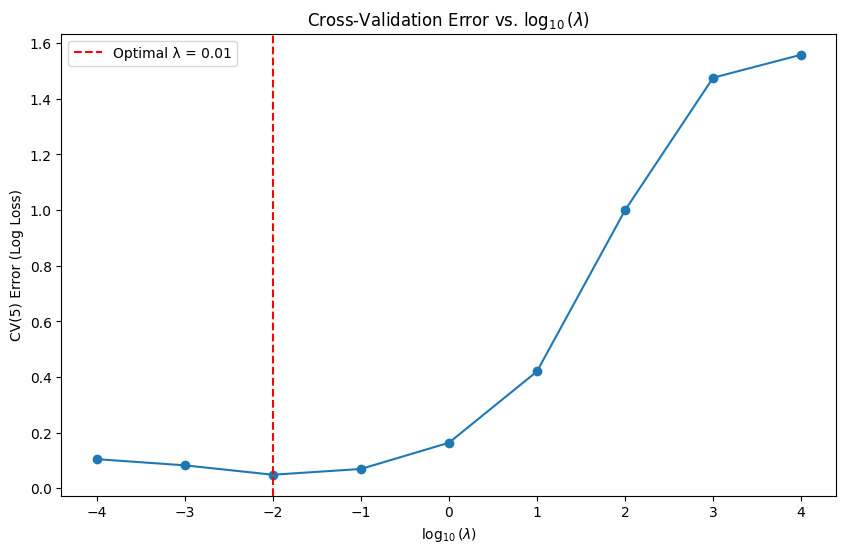

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="'multi_class' was deprecated in version 1.5 and will be removed in 1.7"
)

# Constants
lambda_values = np.logspace(-4, 4, 9)
log_lambda_values = np.log10(lambda_values)
cv_errors = []

# Cross-validation setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for lam in lambda_values:
    # In scikit-learn, C is inverse of regularization strength
    C = 1 / lam
    fold_errors = []
    for train_index, val_index in kf.split(X_scaled):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train model
        model = LogisticRegression(
            penalty='l2',
            C=C,
            solver='lbfgs',
            multi_class='multinomial',
            max_iter=1000
        )
        model.fit(X_train, y_train)

        # Compute validation error (negative log likelihood)
        y_val_pred_proba = model.predict_proba(X_val)
        fold_error = log_loss(y_val, y_val_pred_proba)
        fold_errors.append(fold_error)

    # Average error for lambda
    cv_errors.append(np.mean(fold_errors))

# Find optimal lambda and plot results
optimal_lambda = lambda_values[np.argmin(cv_errors)]
print(f"Optimal lambda: {optimal_lambda}")

plt.figure(figsize=(10, 6))
plt.plot(log_lambda_values, cv_errors, marker='o')
plt.xlabel(r'$\log_{10}(\lambda)$')
plt.ylabel('CV(5) Error (Log Loss)')
plt.title('Cross-Validation Error vs. $\log_{10}(\lambda)$')
plt.axvline(np.log10(optimal_lambda), color='red', linestyle='--', label=f'Optimal λ = {optimal_lambda}')
plt.legend()
plt.show()

# Retraining the Model and Making Predictions
We retrain the logistic regression model using the optimal λ on the full dataset (183 samples). The model calculates probabilities for each of the five ancestry classes for the 111 test individuals and predicts the most probable class for each sample.

In [5]:
# Retrain model on full training data using optimal lambda
C_optimal = 1 / optimal_lambda
model_optimal = LogisticRegression(
    penalty='l2',
    C=C_optimal,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000
)
model_optimal.fit(X_scaled, y)

# Load and preprocess test data
test_data = pd.read_csv("/content/TestData_N111_p10.csv")
X_test = test_data.iloc[:, 1:-1].values  # Features (PC1 to PC10)
y_test = test_data['Ancestry']

X_test_scaled = scaler.transform(X_test)

# Predict probabilities
y_test_pred_proba = model_optimal.predict_proba(X_test_scaled)

# Predicted classes
y_pred_indices = np.argmax(y_test_pred_proba, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_indices)

# Prepare results
probs_df = pd.DataFrame(y_test_pred_proba, columns=label_encoder.classes_)
probs_df['Predicted Class'] = y_pred_labels
probs_df['Actual Class'] = y_test.values

# Function to highlight the highest probability
def highlight_max(row):
    max_val = row[label_encoder.classes_].max()
    return ['background-color: royalblue; color: white;' if v == max_val else '' for v in row[label_encoder.classes_]] + [''] * 2

# Display results
probs_df_style = probs_df.style.apply(highlight_max, axis=1)
probs_df_style

,African,EastAsian,European,NativeAmerican,Oceanian,Predicted Class,Actual Class
0,0.000075,0.000000,0.000000,0.000000,0.999925,Oceanian,Unknown
1,0.000003,0.000000,0.000000,0.999997,0.000000,NativeAmerican,Unknown
2,0.000035,0.000007,0.999958,0.000000,0.000001,European,Unknown
3,0.979294,0.000006,0.000087,0.000923,0.019690,African,Unknown
4,0.000001,0.999999,0.000000,0.000000,0.000000,EastAsian,Unknown
5,0.000183,0.000000,0.000007,0.999810,0.000000,NativeAmerican,Mexican
6,0.005413,0.000000,0.000079,0.994508,0.000000,NativeAmerican,Mexican
7,0.007312,0.000000,0.003046,0.989641,0.000000,NativeAmerican,Mexican
8,0.023545,0.000000,0.000576,0.975879,0.000000,NativeAmerican,Mexican
9,0.050228,0.000000,0.061412,0.888360,0.000000,NativeAmerican,Mexican
